# Decision Trees

### Jack Bennetto
#### October 15, 2018

(based on John Bourassa's lecture, based on my lecture in zipfian, based on the lecture from Jonathan Torrez)

## Objectives

* Describe pros/cons of decision tree algorithm
* Implement pseudocode for decision tree algorithm
* Describe common measures for making splits in a decision tree
* Demonstrate concept of recursion and relate it to decision trees
* State pruning techniques

## Agenda

 * Introduction
 * Predicting with a decision tree
 * Building a decision tree
 * Recursion
 * Loss functions
 * Entropy and purity
 * Decision-tree algorithm
 * Pre- and post-pruning

## Parametric vs. Non-Parametric Models


### Parametric Models

#### Linear Regression


$$\hat y = \hat\beta_0 + \hat\beta_1 X_1 + \hat\beta_2 X_2 + ... + \hat\beta_i X_i $$
    
How many parameters can we describe it with?

Can we ever change the number of parameters?

What does using this model mean about the structure of our data?

## Parametric and Non-Parametric Models

Class discussion: contrast the pros and cons of these two types of models

In [1]:
import numpy as np
import pandas as pd
import scipy
import operator
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets, tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

%matplotlib inline
# Make it pretty
plt.style.use('ggplot')

# Seed random functions for reproducibility
np.random.seed(3)

In [2]:
#Load in iris dataset
iris = datasets.load_iris()
X = iris["data"]
y = iris["target"]

#Reduce the data down to 2 classes and 2 predictor variables
X = X[y != 0, :2] 

#Add some noise so data points aren't exactly duplicated
X = X + np.random.normal(0, .05, size = X.shape)

#Change Sepal Length from cm to mm to cause scaling issues
X[:,0] = X[:,0] * 10
y = y[y != 0] - 1

In [3]:
#Save some points for later
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = .1)

In [4]:
def plot_flower_data(ax, X, y):
    ax.scatter(X[y == 0,0], X[y == 0,1], c = "orange", label = "versicolor")
    ax.scatter(X[y == 1, 0], X[y == 1, 1], color = "black", label = "virginica")
    ax.set_xlabel("Sepal Length (mm)")
    ax.set_ylabel("Sepal Width (cm)")
    ax.legend()

In [5]:
# Create samples from a multivariate normal distribution
# which approximates the input data
def gen_similar_samples(X, y, n_samples = 4, sample_size = 50):
    Xs = []
    ys = []
    for _ in range(n_samples):
        Xdata = np.zeros_like(X)
        ydata = np.zeros_like(y)
        for i, value in enumerate(np.unique(y)):
            Xdata[i*sample_size:(i+1)*sample_size] = np.random.multivariate_normal(X[y == value].mean(axis = 0), 
                                                                                   np.cov(X[y == value].T), 
                                                                                   sample_size)
            ydata[i*sample_size:(i+1)*sample_size] = value
        Xs.append(Xdata)
        ys.append(ydata)
    
    return list(zip(Xs, ys))

In [6]:
# Read in our data
tennis_df = pd.read_table('data/tennis.txt', delim_whitespace=True)

In [7]:
# Clean up a few things, based on my preferences and making calculating probabilities easier
tennis_df.rename(columns={'playtennis': 'played'}, inplace=True)
tennis_df['played'] = tennis_df['played'].apply(lambda x: 1 if x == 'yes' else 0)

In [8]:
# Let's look at the data
tennis_df.sort_values('played')

,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
13,rainy,mild,high,True,0
2,overcast,hot,high,False,1
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
6,overcast,cool,normal,True,1
8,sunny,cool,normal,False,1


## How Would You Determine If You Played Tennis?

Class discussion

You probably need to do `pip install graphviz` to generate this.

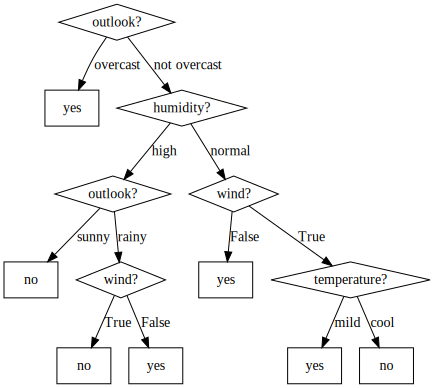

In [9]:
from graphviz import Digraph
dot = Digraph(comment='A simple classification tree')

dot.node('O', 'outlook?', shape='diamond')
dot.node('1', "yes", shape='rectangle')
dot.node('H', 'humidity?', shape='diamond')
dot.node('O2', 'outlook?', shape='diamond')
dot.node('W', 'wind?', shape='diamond')
dot.node('3', 'yes', shape='rectangle')
dot.node('T', 'temperature?', shape='diamond')
dot.node('4', 'yes', shape='rectangle')
dot.node('5', "no", shape='rectangle')
dot.node('2', "no", shape='rectangle')
dot.node('W2', 'wind?', shape='diamond')
dot.node('6', "no", shape='rectangle')
dot.node('7', 'yes', shape='rectangle')

dot.edge('O', '1', 'overcast')
dot.edge('O', 'H', 'not overcast')
dot.edge('H', 'O2', 'high')
dot.edge('H', 'W', 'normal')
dot.edge('W', '3', 'False')
dot.edge('W', 'T', 'True')
dot.edge('T', '4', 'mild')
dot.edge('T', '5', 'cool')
dot.edge('O2', '2', 'sunny')
dot.edge('O2', 'W2', 'rainy')
dot.edge('W2', '7', 'False')
dot.edge('W2', '6', 'True')
dot

A **decision tree** is a machine-learning model that chooses a label based a series of questions, each about the value of one of the features, with each question based on the result of the previous one.

### Predicting from a decision tree

A decision tree is a binary tree, with each branch (non-leaf) node having a left and right child node. Each branch node specifies a feature to split along with information on which values should pass to the left node, and which should pass to the right.

In general that's specified with a single split value for each node. For numeric features, if that feature for a data point is less than the split value the data point is handled by the left node; if not, it's handled by the node on the right. For categorical features, if the feature is equal to the split value it is handled on the left, otherwise the right.

Decision trees can be used for either classification or regression. For classification, the leaf nodes will predict probability the data point is in one class or the other. For regression, the leaf nodes predict a specific value.

## Building a regression tree
### Example: insect wing sizes

Load the dataset below.

In [10]:
insects = pd.read_csv('data/insects.csv')
insects.head(10)

,continent,sex,latitude,wingsize
0,1,0,40.5,941.111111
1,1,0,42.0,924.444444
2,1,0,43.6,924.204444
3,1,0,45.7,915.217778
4,1,0,45.9,905.471111
5,1,0,47.4,896.004444
6,1,0,50.0,913.000000
7,1,0,51.8,916.440000
8,1,0,53.8,933.417778
9,1,0,54.8,934.240000


**Discussion:** You want predict insect wingsize from the other features. Suppose you want to build a tree with a single branch, based on one of the three features. Which feature should you choose? What should you predict?

**Discussion:** Suppose instead you were building a classifier, predicting the sex from the other features. How would the answer differ?

What if you were building a deeper tree?

## An aside on recursion

Recursion uses the idea of "divide and conquer" to solve problems. It divides a complex problem you are working on into smaller sub-problems that are easily solved, rather than trying to solve the complex problem directly.

Recursive functions split the problem into two cases: the ***base case*** and the ***recursive case***. The function continually calls *itself* until it reaches the base case.

* Base case: Stopping criteria, the simplest case that can be solved directly.
* Recursive case: Function that splits the problem into the smaller subproblems.
    
### Three Laws of Recursion

1. A recursive algorithm must have a base case.
2. A recursive algorithm must call itself, recursively.
2. A recursive algorithm must call itself with different arguments so as to move it toward the base case.

### Example: Factorial

Are the following functions the same?

$$ f(x) = \prod_{i=1}^xi $$

$$f(x) =
\left\{
	\begin{array}{ll}
		1  & \mbox{if } x \leq 1 \\
		xf(x-1) & \mbox otherwise
	\end{array}
\right.
$$

Let's code this together.

In [11]:
def factorial(x):
    """Recursively calculate x!"""
    # base case is when we get to x=0, which is 0! = 1

Let's try another together.

In [12]:
def power(base, exp):
    """Recrsively caclulate base ** exp"""

Fill in the following function

In [13]:
def len_str(s):
    """Recursively determine the length of a string"""
    # base case, when should you stop?  
    # recursive case, how can you reduce your problem?

**Question:** suppose you had a decision tree that was composed of `TreeNode` objects, each of which had a `left` and `right` child. How would you use recursion to predict the value of a data point?

## Fitting a decision tree

To fit a decision tree, we want to find the split that will minimize our loss function. To do this we consider every possible feature in our training data, and for each feature consider every possible value, and of all those choose the one for which the loss function is smallest.

Once we've chosen our top-level split, we separate our data into two parts (for the left and right part). For each of those we again find the split that minimizes the loss function, and continue, recursively.

At some point we stop and produce a leaf node, maybe when we just have one data point or when all the features for a point are identical, or maybe earlier (we'll talk more about this later).

Question: What should we predict if we're building a regression tree? A classification tree?

## Loss functions

For a regression tree we generally used the mean squared residuals.

$$\frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2$$

where $y_i$ is the actual value for data point $i$ and $\hat{y}_i$ is the predicted probability.

There are a couple choices for loss functions for binary classifiers. The most common is log loss, 

$$-\frac{1}{N} \sum_{i=0}^N y_i \log{\hat{p}_i} + (1 - y_i) \log{(1 - \hat{p}_i)}$$

where $\hat{p}_i$ is the predicted probability that $y_i$ is $1$.

Another approach is Brier score loss,

$$\frac{1}{N} \sum_{i=1}^N (y_i - \hat{p}_i)^2$$


### Alternative formulation: minimizing impurity

There's another way of seeing this that's more common but (in our opinion) is more confusing. We can also talk choosing the feature and value for the split that separates the data so the left and right sides are each as "pure" as possible. This is called "minimizing the impurity".

In the case of regression, we measure the impurity of the data as the variance, and the total impurity after the split is the average if the data on the left side and the data on the right, **weighted by the number of points in each**.

Minimizing this is exactly equivalent to minimizing the mean squared residual. The variance is the average sum of difference of the points and their mean, which is just our predicted value.

In the case if classification, we have two ways we can define impurity. One option is using the **Shannon entropy**, which is a measure of information the of random variable or set of options.

Entropy is given by

$$H(X) = -\sum_i p_i \log_2{p_i}$$

where $p_i$ is the number of data in class $i$.


This is **equivalent to minimizing log loss** (to within a constant factor, since Shannon entropy is generally defined with a base-2 logarithm).

The other option is called Gini impurity. The Gini impurity can be defined in a number of ways, but one is that, assuming you predict classes randomly according to their probability, the probability that you are wrong. The Gini impurity is equal to 

$$H(X) = 1 - \sum_i p_i^2$$

This is **equivalent to minimizing the Brier score loss.**

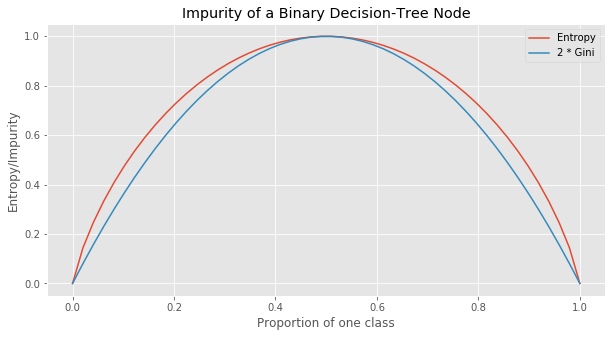

In [14]:
def xlog2x(x):
    '''return x * log2(x), returning 0 for x==0'''
    return scipy.special.xlogy(x,x) / np.log(2)

x = np.linspace(0, 1)
entropy = - (xlog2x(x) + xlog2x(1-x))
gini = 2 * (1 - x**2 - (1-x)**2)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, entropy, label="Entropy")
ax.plot(x, gini, label="2 * Gini")
ax.set_ylabel("Entropy/Impurity")
ax.set_xlabel("Proportion of one class")
ax.set_title("Impurity of a Binary Decision-Tree Node")
ax.legend()

In [15]:
def calc_entropy(y):
    """Return the entropy of the array y.
    
    Parameters
    ----------
    y: 1d numpy array
    
    Returns
    -------
    float
    """
    total_samples = y.shape[0]
    summation = 0
    
    for class_i in np.unique(y):
        prob = sum(y == class_i) / float(total_samples)
        summation += prob * np.log2(prob)
    
    return -summation

In [16]:
y_tennis = tennis_df['played'].values

print("Entropy of original data set is {}".format(calc_entropy(y_tennis)))

Entropy of original data set is 0.9402859586706311


### Choosing a split

In order to figure out the best split, we need to figuring out which minimizes the entropy, or minimizes the Gini impurity, for both sides of the split.

This is **weighted by the number of data points on each side.**

We generally look at the change in the total impurity from before the split to after.

$$\text{IG}(S, C) = H(S) - \sum_{C_i \in C} \frac{|C_i|}{|S|} H(C_i)$$

where 

$C$ = candidate partition of $S$,  and $|C_i|$, $|S|$ = Number of elements in $C_i$, $S$, and $H$ is the impurity/entropy of the data.

In [17]:
def calc_info_gain(y, y1, y2, impurity_func):
    """Return the information gain of making the given split.
    
    Parameters
    ----------
    y: 1d numpy array
        Labels for parent node
    
    y1: 1d numpy array
        Labels for potential child node 1
    
    y2: 1d numpy array
        Labels for potential child node 2
    
    impurity_func: function
        Function which calculates the impurity of the node 
        (e.g. Shannon Entropy)
    
    Returns
    -------
    float
    """
    total_samples = float(y.shape[0])
    child_imp = 0
    y_impurity = impurity_func(y)
    
    for child_node in (y1, y2):
        child_num = child_node.shape[0]
        child_imp += (child_num / total_samples) * impurity_func(child_node)
        
    return y_impurity - child_imp

In [18]:
# Let's split on the temperature.

y1 = tennis_df[tennis_df['temperature'] == 'hot']['played'].values
y2 = tennis_df[tennis_df['temperature'] != 'hot']['played'].values

In [19]:
print("Information Gain is {0}.".format(calc_info_gain(y_tennis, y1, y2, calc_entropy)))

Information Gain is 0.02507817350585062.


In [20]:
# Not much gain, maybe I really liked playing when the temperature was mild
# Let's try that split

y1 = tennis_df[tennis_df['temperature'] == 'mild']['played'].values
y2 = tennis_df[tennis_df['temperature'] != 'mild']['played'].values

In [21]:
print("Information Gain is {0}.".format(calc_info_gain(y_tennis, y1, y2, calc_entropy)))

Information Gain is 0.0013397424044413464.


In [22]:
# Still not much headway, let's just try every possible split and see what works
# And also confirm what we used our common sense algorithm we started with

possible_splits = {}
# Get just my features from the dataframe
feature_cols = tennis_df.drop('played', axis=1).columns

# For a given column, find all the unique possible values
for col in feature_cols:
    col_splits = np.unique(tennis_df[col])
    # For each possible value, split the dataset using that value
    for pos_val in col_splits:
        y1 = tennis_df[tennis_df[col] == pos_val]['played'].values
        y2 = tennis_df[tennis_df[col] != pos_val]['played'].values
        # Calculate the information gain, save it for later
        ig = calc_info_gain(y_tennis, y1, y2, calc_entropy)
        key = "{0}: {1}".format(col, pos_val)
        possible_splits[key] = ig

In [23]:
# Print out our results in a pretty way
colname1 = "Col Name: Value"
colname2 = "Information Gain"

# :20 is specifying a column width, https://docs.python.org/3/library/string.html#formatspec
print("{0:20} || {1}".format(colname1, colname2))
print("-"*40)
# operator.itemgetter(1) allows us to sort by the second item of the tuple
for k,v in sorted(possible_splits.items(), key=operator.itemgetter(1), reverse=True):
    print("{0:20} || {1}".format(k, round(v, 4)))
    

Col Name: Value      || Information Gain
----------------------------------------
outlook: overcast    || 0.226
humidity: high       || 0.1518
humidity: normal     || 0.1518
outlook: sunny       || 0.1022
wind: False          || 0.0481
wind: True           || 0.0481
temperature: hot     || 0.0251
temperature: cool    || 0.015
outlook: rainy       || 0.0032
temperature: mild    || 0.0013


In [24]:
# Splitting on overcast gave us the largest info gain
# Let's look at what those child nodes look like and their respective entropies
child_node_left = tennis_df[tennis_df['outlook'] == 'overcast']
print("Entropy of left child node is {0}".format(
          calc_entropy(child_node_left['played'].values)))
child_node_left

Entropy of left child node is -0.0


,outlook,temperature,humidity,wind,played
2,overcast,hot,high,False,1
6,overcast,cool,normal,True,1
11,overcast,mild,high,True,1
12,overcast,hot,normal,False,1


In [25]:
# Ok, we got a pure node, that makes sense.
# What about the other node?
child_node_right = tennis_df[tennis_df['outlook'] != 'overcast']
print("Entropy of right child node is {0}".format(
          calc_entropy(child_node_right['played'].values)))
child_node_right

Entropy of right child node is 1.0


,outlook,temperature,humidity,wind,played
0,sunny,hot,high,False,0
1,sunny,hot,high,True,0
3,rainy,mild,high,False,1
4,rainy,cool,normal,False,1
5,rainy,cool,normal,True,0
7,sunny,mild,high,False,0
8,sunny,cool,normal,False,1
9,rainy,mild,normal,False,1
10,sunny,mild,normal,True,1
13,rainy,mild,high,True,0


### What's the difference between entropy and Gini impurity?

**Class workshop:** Assume we're using a decision tree to classify, have 50 spam and 50 non-spam emails in our training set, and have many different features that result in different splits. Make up to splits, one which is favored using entropy, the other is favored by Gini impurity.

### How would you know how to stop?

**Class discussion:** When would you stop? Potential problems?

Will get to this soon.

## DT Pseudocode

Recursive partitioning algorithm

```
function BuildTree:
    # base case, stop building tree
    If every item in the dataset is in the same class
    or there is not feature left to split the data:
        return a leaf node with the class label
    # recursive case, keep splitting stuff
    Else:
        find the best feature and value to split the data
        split the dataset
        create a node
        for each split
            call Build Tree and add the result as a child of the node
        return node
```

## Performance of Decision Trees

Class discussion: what are some problems you foresee with this approach?

In [26]:
def plot_classification_tree(ax, X, y, model=None, fit = True):
    ax.plot(X[y==0, 0], X[y==0, 1], 'r.', label='versicolor')
    ax.plot(X[y==1, 0], X[y==1, 1], 'b.', label='virginica')
    ax.set_title("Classifying Iris with Decision Trees")
    ax.set_xlabel("Sepal Length (mm)")
    ax.set_ylabel("Sepal Width (cm)")
    ax.legend(loc='upper left')
    
    if model is None:
        model = tree.DecisionTreeClassifier()
    if fit:
        model.fit(X, y)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    plot_classification_thresholds(ax, X, y, 0, model.tree_, xlim, ylim)
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

def plot_classification_thresholds(ax, X, y, inode, tree, xlim, ylim):
    threshold = tree.threshold[inode]
    if tree.feature[inode] == -2:
        color = ['r', 'b'][np.argmax(tree.value[inode])]
        ax.add_patch(Rectangle((xlim[0], ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0], fc=color, alpha=0.3))
        return
    if tree.feature[inode] == 0:
        ax.plot((threshold, threshold), ylim, 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, (xlim[0], threshold), ylim)
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, (threshold, xlim[1]), ylim)
    else:
        ax.plot(xlim, (threshold, threshold), 'k', lw=0.5)
        plot_classification_thresholds(ax, X, y, tree.children_left[inode],  tree, xlim, (ylim[0], threshold))
        plot_classification_thresholds(ax, X, y, tree.children_right[inode], tree, xlim, (threshold, ylim[1]))        


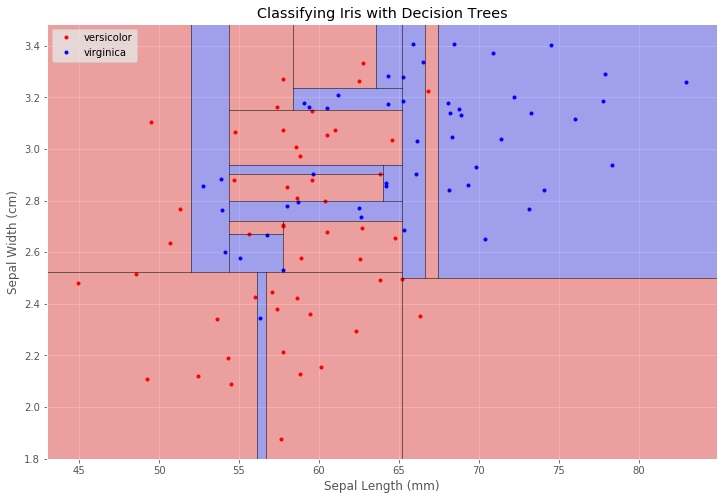

In [27]:
X, y = gen_similar_samples(X, y, 1)[0]
model = tree.DecisionTreeClassifier()
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y, model)

Clearly there is some risk of overfitting.

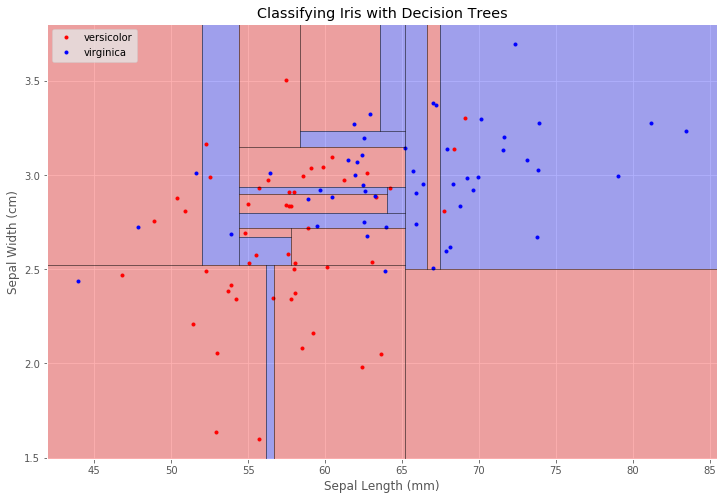

In [28]:
X, y = gen_similar_samples(X, y, 1)[0]
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y, model, fit = False)

#### What if we don't let it split so many times?

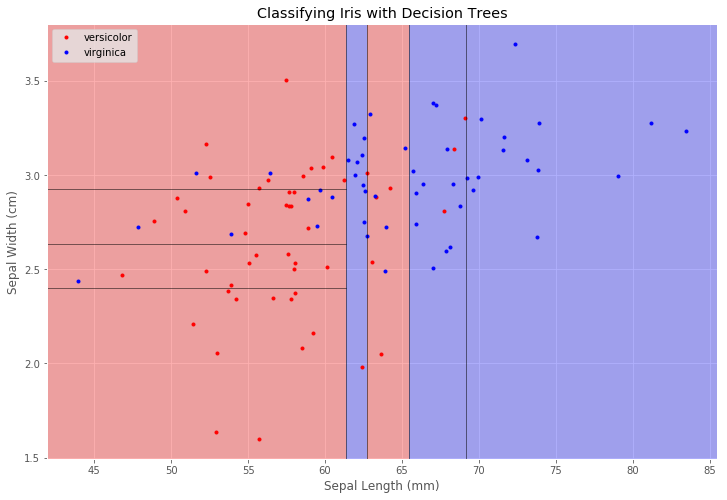

In [29]:
model = tree.DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 10)
fig, ax = plt.subplots(figsize=(12,8))
plot_classification_tree(ax, X, y, model)

## Picking the Best Tree

* Cross validate!
    * Train trees with different parameters, see which performs best on validation set
    * No different than any other model

## Pruning

We call the idea of modifying a decision tree to improve its performance **pruning**.

There are two approaches: **pre-pruning** (limiting the tree as we build it) and **post-pruning** (sometimes just called "pruning"; chopping back the tree after it is built.

### Pre

Prune as we build the tree, control hyper-parameters

Class discussion: what can we control?

In [30]:
help(tree.DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int or None, optional (default=None)
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int, float, optional (default=2)

### Post

Post-pruning (also just called pruning) involves cutting back the tree after it's been built based on the test-set error.

* Merge leaves if doing so decreases *test-set* error
* If not leaves, consider each branch first (recursively)

#### Pseudocode
```
function Prune:
    if either left or right is not a leaf:
        call Prune on those that aren't
    if both left and right are (now) leaf nodes:
        calculate error associated with merging two leaf nodes
        calculate error associated without merging two leaf nodes
        if merging results in lower error:
            merge the leaf nodes
```

## Pros and Cons of Decision Trees

Class discussion: what do you think?

## The Decision Tree Algorithms

There are some famous variants of the decision tree algorithm:

### ID3

Short for Iterative Dichotomiser 3, the original Decision Tree algorithm developed by Ross Quinlan (who's responsible for a lot of proprietary decision tree algorithms) in the 1980's.

* designed for only categorial features
* splits categorical features completely
* uses entropy and information gain to pick the best split

### CART

Short for Classification and Regression Tree was invented about the same time as ID3 by Breiman, Friedman, Olshen and Stone. The CART algorithm has the following properties:

* handles both categorial and continuous data
* always uses binary splits
* uses gini impurity to pick the best split

Algorithms will be called CART even if they don't follow all of the specifications of the original algorithm.

### C4.5

This is Quinlan's first improvement on the ID3 algorithm. The main improvements are:

* handles continuous data
* implements pruning to reduce overfitting

### C5.0

This is supposedly better, but it's proprietary so we don't have access to the specifics of the improvements.